# SVD против CUR в задаче сжатия нейронных сетей

In [1]:
import pandas as pd
import torch
from itertools import product
from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from tqdm import tqdm

## Эксперименты с MNIST

### Загрузка данных

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32, 32), antialias=True),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [3]:
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=False)

Нарисуем несколько примеров из обучающей и тестовой выборок.

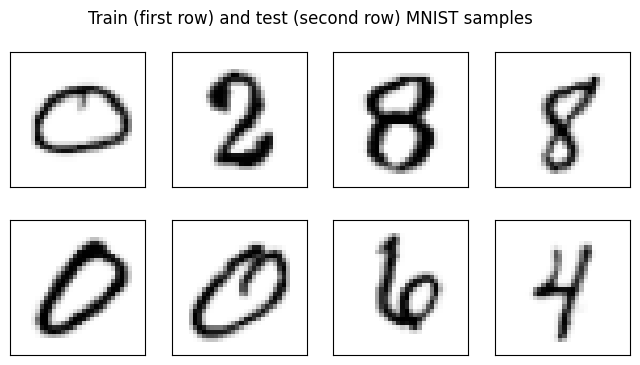

In [5]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) MNIST samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0][0, ...], cmap="Greys")
    ax[1, i].imshow(test_dataset[test_id][0][0, ...], cmap="Greys")

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [6]:
vgg11 = models.vgg11()
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Настройка модели VGG-11

In [7]:
def freeze(module: torch.nn.Module):
    # TODO: 1) убрать в модуль utils; 2) добавить docstring
    for param in module.parameters():
        param.requires_grad = False
    module.eval()

def unfreeze(module: torch.nn.Module):
    # TODO: 1) убрать в модуль utils; 2) добавить docstring
    for param in module.parameters():
        param.requires_grad = True
    module.train()

In [8]:
def count_parameters(model: torch.nn.Module):
    # TODO: 1) убрать в модуль utils; 2) добавить docstring
    total_params = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()

    return total_params

Исследуем число параметров в разных слоях VGG-11.

In [9]:
# TODO: заменить эту шляпу на функцию describe_nn (название от балды), которая сделает красивую табличку про слои или фичи
total_params = count_parameters(vgg11)
nn_blocks = {
    "features" : vgg11.features,
    "avgpool" : vgg11.avgpool,
    "classifier" : vgg11.classifier
}
df = pd.DataFrame(
    index=nn_blocks.keys(),
    data={
        "num_features" : [ count_parameters(block) for block in nn_blocks.values() ],
        "%_features" : [ 100.0 * count_parameters(block) / total_params for block in nn_blocks.values() ]
    }
)

In [10]:
print(f"Total parameters for VGG11: {total_params}")
df

Total parameters for VGG11: 132863336


,num_features,%_features
features,9220480,6.939823
avgpool,0,0.000000
classifier,123642856,93.060177


In [11]:
vgg11.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Как можно заметить, большинство параметров в модели находится в слое-классификаторе, состоящем из полносвязных слоёв. Именно для
них и будем применять разложения.

Сначала заменим слой-классификатор таким образом, чтобы число выходных слоёв модели совпадало с числом классов в нашей задаче.

In [12]:
vgg11.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(),
    torch.nn.Linear(4096, 10)
)
freeze(vgg11.features)
freeze(vgg11.avgpool)

### Цикл обучения

In [13]:
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def train_model(model, dataloader, loss_fn, optimizer, epochs, scheduler, device='cpu'):
    # TODO: 1) убрать в модуль utils; 2) добавить docstring
    model.to(device).train()
    for _ in range(epochs):
        for input, target in (pbar := tqdm(dataloader)):
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = loss_fn(output, target)
            pbar.set_description(f"Loss: {loss.item()}")
            loss.backward()
            optimizer.step()
        scheduler.step()

In [15]:
def test_model(model, dataloader, device='cpu'):
    # TODO: 1) убрать в модуль utils; 2) добавить docstring
    model.to(device).eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input, target in tqdm(dataloader):
            input, target = input.to(device), target.to(device)
            output = model(input).argmax(dim=1)
            correct += (output == target).sum()
            total += target.numel()
    print(f"Correctly classified targets: {correct} / {total}")
    print(f"Total accuracy: {100.0 * correct / total}%")

In [16]:
optimizer = torch.optim.Adam(vgg11.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = torch.nn.CrossEntropyLoss()

train_model(vgg11, train_dataloader, loss_fn, optimizer, EPOCHS, scheduler, DEVICE)

Loss: 0.12762397527694702: 100%|██████████| 3750/3750 [01:46<00:00, 35.19it/s]  


In [17]:
test_model(vgg11, test_dataloader, DEVICE)

100%|██████████| 625/625 [00:03<00:00, 195.31it/s]

Correctly classified targets: 9472 / 10000
Total accuracy: 94.72000122070312%
